## Using the dataset, build a model that can forecast ticket volume

In [1]:
# basic packages
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#data specific package
from pandas.tseries.holiday import USFederalHolidayCalendar

warnings.filterwarnings(
    action="ignore"
)

In [2]:
# importing dataset
df = pd.read_csv("Data/MR_DS.csv")

# data start and end date
start_date = '2015-11-24'
end_date = '2016-04-21'

In [3]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count
0,4/21/2016,533,984,507,239,240
1,4/20/2016,658,6035,485,225,210
2,4/19/2016,778,2450,500,196,231
3,4/18/2016,743,2502,527,192,240
4,4/17/2016,925,3080,488,217,209


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null object
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: int64(5), object(1)
memory usage: 7.1+ KB


In [5]:
# convert date to datetime object to apply transformations
df["Ticket Created Date"] = pd.to_datetime(df["Ticket Created Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null datetime64[ns]
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 7.1 KB


In [6]:
# create season feature: winter, spring, summer, fall
df["Season"] = "Winter"
df["Season"][(df["Ticket Created Date"].dt.month > 2) & (df["Ticket Created Date"].dt.month <= 5)]  = "Spring"
df["Season"][(df["Ticket Created Date"].dt.month > 5) & (df["Ticket Created Date"].dt.month <= 8)]  = "Summer"
df["Season"][(df["Ticket Created Date"].dt.month > 8) & (df["Ticket Created Date"].dt.month <= 11)]  = "Fall"
df.Season.unique()

array(['Spring', 'Winter', 'Fall'], dtype=object)

In [7]:
# linear model doesn't accept categories, one hot encoding to accommodate
one_hot = pd.get_dummies(df["Season"])
df = df.drop("Season", axis=1)
df = df.join(one_hot)

In [8]:
# create holiday feature
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)
df["Holiday"] = np.where(df["Ticket Created Date"].isin(holidays), "Holiday", "Not Holiday")
list(holidays)

[Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-18 00:00:00'),
 Timestamp('2016-02-15 00:00:00')]

In [9]:
one_hot = pd.get_dummies(df["Holiday"])
df = df.drop("Holiday", axis=1)
df = df.join(one_hot)

In [10]:
# check weekday vs weekend
df["Weekday"] = np.where(pd.DatetimeIndex(df["Ticket Created Date"]).weekday < 5, "Weekday", "Weekend")
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,Weekday
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,Weekday
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,Weekday
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,Weekday
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,Weekend


In [11]:
one_hot = pd.get_dummies(df["Weekday"])
df = df.drop("Weekday", axis=1)
df = df.join(one_hot)

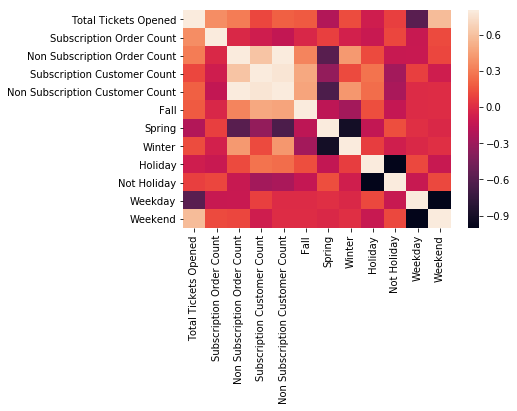

In [12]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [13]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday,Weekend
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,1,0
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,1,0
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,1,0
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,1,0
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,0,1


In [14]:
# original algorithm without any reduction
rgr = LinearRegression()
Y = df["Total Tickets Opened"]
X = df.iloc[:, 2:]

# splitting dataset into training data and testing data to validate model using holdout groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 4.65204459e-02  2.56657856e-01 -5.09203822e-01  3.62870671e-01
  1.02781154e+02 -8.54118236e+01 -1.73693303e+01 -1.98107015e+01
  1.98107015e+01 -1.02428914e+02  1.02428914e+02]

Intercept: 
 524.4623669323965

Accuracy:
 0.5956257883925662


In [15]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.17202692 -0.01897535 -2.24802835]


In [16]:
# try to simplify equation based on correlation heatmap; keeping all seasons
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Spring", "Winter", "Holiday", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 5.75344441e-02  5.15637313e-02  1.18501545e+02 -1.14270336e+02
 -4.23120941e+00 -5.31970532e+01 -1.98042196e+02]

Intercept: 
 748.1941755872688

Accuracy:
 0.5719107169132132


In [17]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.30152545 -0.22659224  0.15079465]


In [18]:
# further simplification, although because dataset doesn't include any "Summer", may have adverse effects with inclusion of summer data
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Winter", "Holiday", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 5.00954304e-02  2.09422937e-01  1.90533888e+02  6.66048841e+01
 -5.58900946e+01 -2.30563214e+02]

Intercept: 
 667.9440725977466

Accuracy:
 0.4481376638083804


In [19]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [0.27584636 0.09111936 0.7724479 ]


In [20]:
# instead of weekday v weekend, check day
df = df.drop(['Weekday', 'Weekend'], axis=1)

In [21]:
df['Day of Week'] = pd.DatetimeIndex(df["Ticket Created Date"]).weekday
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 6, 'Sunday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 5, 'Saturday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 4, 'Friday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 3, 'Thursday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 2, 'Wednesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 1, 'Tuesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 0, 'Monday')

In [22]:
one_hot = pd.get_dummies(df["Day of Week"])
df = df.drop("Day of Week", axis=1)
df = df.join(one_hot)
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,0,0,0,0,1,0,0
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,0,0,0,0,0,0,1
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,0,0,0,0,0,1,0
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,0,1,0,0,0,0,0
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,0,0,0,1,0,0,0


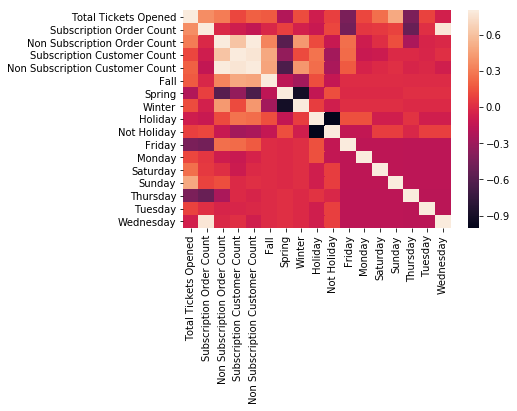

In [23]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [24]:
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Spring", "Winter", "Holiday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 3.00646450e-02  5.69019037e-01  9.30106489e+01 -8.30374383e+01
 -9.97321062e+00 -6.05097134e+01  6.81933796e+01  4.89513138e+01
 -9.94267137e+01 -1.49428153e+02 -1.75989329e+02  1.05955545e+02
  2.01743957e+02]

Intercept: 
 526.8663896948987

Accuracy:
 0.7459122840959693


In [25]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.44579978  0.3347209  -0.21205828]


In [26]:
# day of week is more accurate than weekday & weekend. keep day of week
df.to_csv("Data/Modified_MR_DS.csv")

In [27]:
las = Lasso()
las.fit(X_train, Y_train)

print('\nCoefficients: \n', las.coef_)
print('\nIntercept: \n', las.intercept_)
print('\nAccuracy:\n', las.score(X_train, Y_train))


Coefficients: 
 [ 4.14797987e-02  6.53391103e-01  7.22537919e+01 -6.42849004e+01
 -0.00000000e+00 -2.95149898e+01  7.39397823e+00  0.00000000e+00
 -1.67750657e+02 -1.72068105e+02 -2.04334707e+02  4.73613449e+01
  1.40659741e+02]

Intercept: 
 512.8593865305427

Accuracy:
 0.7419414042222092


In [28]:
print('\nCross Validation of test data:\n',cross_val_score(las, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.45316209  0.33824633 -0.10542181]


In [29]:
rid = Ridge()
rid.fit(X_train, Y_train)

print('\nCoefficients: \n', rid.coef_)
print('\nIntercept: \n', rid.intercept_)
print('\nAccuracy:\n', rid.score(X_train, Y_train))


Coefficients: 
 [ 4.66526256e-02  6.34684155e-01  7.78519261e+01 -7.30568716e+01
 -4.79505448e+00 -4.97743821e+01  6.11290292e+01  4.54755149e+01
 -1.29900692e+02 -1.11954613e+02 -1.42912062e+02  9.62385807e+01
  1.81924242e+02]

Intercept: 
 461.47597669240804

Accuracy:
 0.7423015143590934


In [30]:
print('\nCross Validation of test data:\n',cross_val_score(rid, X_test, Y_test, cv=3))


Cross Validation of test data:
 [0.6037622  0.29437425 0.32327458]
